<a class="anchor" id="h0"></a>

<br/><br/>
# Анализ покупок интернет магазина
Продакт-менеджер просит нас ответить на следующие вопросы:
    1. Сколько у нас пользователей, которые совершили покупку только один раз?
    2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
    3. По каждому товару определить, в какой день недели товар чаще всего покупается.
    4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
    5. В период с января по декабрь выявить когорту пользователей с самым высоким retention на 3й месяц.
    6. Построй RFM-сегментацию пользователей
## Оглавление
* [1. Открываем файлы, изучаем данные](#h1)
    * [1.1 Знакомимся с пользователями](#h1_1)
    * [1.2 Знакомимся с заказами](#h1_2)
    * [1.3 Знакомимся с товарами в заказах](#h1_3)
* [2. Предобработка данных](#h2)
* [3. Приступаем к Анализу](#h3)
    * [3.1 Сколько у нас пользователей, которые совершили покупку только один раз?](#h3_1)
    * [3.2 Сколько заказов в месяц в среднем не доставляется по разным причинам?](#h3_2)
    * [3.3 По каждому товару определить, в какой день недели товар чаще всего покупается](#h3_3)
    * [3.4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?](#h3_4)
    * [3.5 В период с января по декабрь выявить когорту пользователей с самым высоким retention на 3й месяц.](#h3_5)
    * [3.6 Построй RFM-сегментацию пользователей](#h3_6)
* [Выводы](#h4)


### Импортируем библиотеки

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter
import numpy as np
from matplotlib import style
style.use('dark_background')

<a class="anchor" id="h1"></a>

<br/><br/>
<br/><br/>

# 1. Открываем файлы, изучаем данные


При считывание файлов преобразуем необходимые колонки с датами в подходящий тип

In [2]:
customers = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SRXJBQaTIRVZkQ')

In [3]:
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/0zWmh1bYP6REbw',
                    parse_dates=[3,4,5,6,7])


In [4]:
items = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/YYEHfWxXE3QwNg', 
                   parse_dates=['shipping_limit_date'])

<a class="anchor" id="h1_1"></a>

<br/><br/>
### 1.1 Знакомимся с пользователями


customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [5]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [7]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


 Пропущеных строк в полях нет, типы данных соответствуют.\
 На один `customer_unique_id` приходится несколько `customer_id`

<a class="anchor" id="h1_2"></a>

<br/><br/>
### 1.2 Знакомимся с заказами

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


Колонки `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date` имеют пропущенные значения в строках.\
Прослеживается воронка от создания заказа до его доставки, странно что основные потери на стадиии логистики.\
Типы данных соответствуют.

Все последние заказы начиная с `2018-08-29 15:00:37` имеют статус `canceled`, за исключением одного

In [9]:
orders.sort_values('order_purchase_timestamp',ascending = False).head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
60938,10a045cdf6a5650c21e9cfeb60384c16,a4b417188addbc05b26b72d5e44837a1,canceled,2018-10-17 17:30:18,NaT,NaT,NaT,2018-10-30
68373,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,NaT,NaT,NaT,2018-11-12
31891,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,NaT,NaT,NaT,2018-10-16
88500,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,NaT,NaT,NaT,2018-10-23
50387,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,canceled,2018-09-29 09:13:03,NaT,NaT,NaT,2018-10-15


In [10]:
# Уникальные статусы заказов
print(*orders['order_status'].unique(),sep='; ')

delivered; invoiced; shipped; processing; unavailable; canceled; created; approved


<a class="anchor" id="h1_3"></a>

<br/><br/>
### 1.3 Знакомимся с товарами в заказах

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [11]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


In [12]:
items.price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

In [13]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [14]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


`32951` уникальных товаров

Пропущеных строк в полях нет, типы данных соответствуют

## Выводы

Таблицы с пользователями и товарами в порядке\
С заказами нужно поработать

<a class="anchor" id="h2"></a>

<br/><br/>
<br/><br/>
# 2. Предобработка данных 

Более подробно познакомимся с таблицей о заказах, проверим подтверждается ли статут `delivered`, наличием подтвержденной оплаты и временем доставки

* Посмотрим есть ли заказы у которых отсутствует дата доставки, при этом статус `delivered`

In [15]:
orders.query('order_delivered_customer_date.isnull() and order_status == "delivered"')\
    [['order_id','order_status','order_delivered_customer_date']].head(2).style\
    .highlight_null('yellow')\

,order_id,order_status,order_delivered_customer_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,delivered,NaT
20618,f5dd62b788049ad9fc0526e3ad11a097,delivered,NaT


Видим что дата доставки не указана
<br/><br/>
* Посмотрим есть ли заказы у которых указанно время доставки но, статус отличен от `delivered`

In [16]:
orders.query('order_delivered_customer_date.notnull() and order_status != "delivered"')\
    [['order_id','order_status','order_delivered_customer_date']].head(2)

,order_id,order_status,order_delivered_customer_date
2921,1950d777989f6a877539f53795b4c3c3,canceled,2018-03-21 22:03:51
8791,dabf2b0e35b423f94618bf965fcb7514,canceled,2016-10-16 14:36:59


Видим что есть закрытые заказы, но указанно время доставки
<br/><br/>
* Посмотрим есть ли заказы со статусом `delivered`, но без времени подтверждения оплаты

In [17]:
orders.query('order_status == "delivered" and order_approved_at.isnull()')\
    [['order_id','order_status','order_approved_at']].head(2).style\
    .highlight_null('yellow')\

,order_id,order_status,order_approved_at
5323,e04abd8149ef81b95221e88f6ed9ab6a,delivered,NaT
16567,8a9adc69528e1001fc68dd0aaebbb54a,delivered,NaT


Как видим статус `delivered` не всегда подтверждается начилием даты подтвержденной оплаты и датой доставки.\
Будем считать что заказ *гарантированно* "успешен" если все обязательства между продавцом и покупателем выполнены; 
   * Заказ оплачен (Зафиксировано время подтверждения оплаты)
   * Заказ доставлен (Зафиксировано время доставки, Статус  `delivered`
   
На основе этого добавим новое поле, которое будет принимать значение `1`, если заказ гарантированно успешен и значение `0` - во всех других случаях

In [18]:
orders['order_successful'] = (orders.apply(lambda x: x['order_status'] == 'delivered' 
                                           and x['order_approved_at'] is not pd.NaT
                                           and x['order_delivered_customer_date'] is not pd.NaT, axis = 1)
                             )*1                    

Посмотрим распределение заказов на все статусы по месяцам

In [19]:
orders['month_year'] = orders.order_purchase_timestamp.dt.to_period("M")

In [20]:
order_status = orders.groupby(['month_year','order_status'],as_index = False).agg({'order_id':'count'})

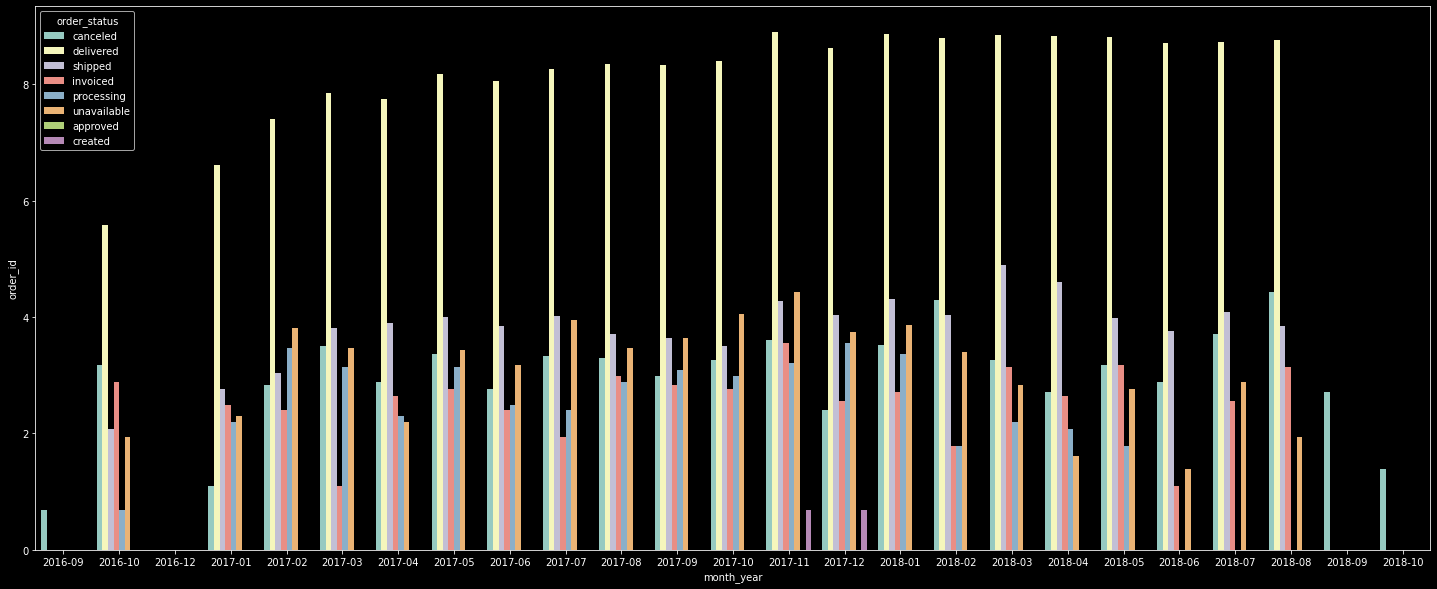

In [21]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(data = order_status, x='month_year', y=np.log(order_status.order_id), hue='order_status')

In [22]:
orders.query('order_successful == 0')\
    ['order_purchase_timestamp'].max() - orders.query('order_successful == 1')['order_purchase_timestamp'].max()

Timedelta('49 days 02:29:41')

Почти 50 дней мы имеем только закрытые заказы, кажется дела идут плохо. Будем иметь в виду эту информацию

<a class="anchor" id="h3"></a>

<br/><br/>

# 3. Приступаем к Анализу

<a class="anchor" id="h3_1"></a>

<br/><br/>

### 3.1 Сколько  пользователей,  совершили покупку только один раз?

In [23]:
orders_customers = orders.merge(customers ,on = 'customer_id')
purchases_per_user = orders_customers.query('order_successful == 1').\
            customer_unique_id.value_counts().to_frame().reset_index().\
            groupby('customer_unique_id',as_index = False).agg({'index':'count'}).\
            rename(columns={'customer_unique_id':'number_purchases','index':'number_of_users'})\

purchases_per_user['percentage_share'] = round(purchases_per_user['number_of_users'] \
                                               / sum(purchases_per_user['number_of_users'])*100,3)

In [24]:
purchases_per_user.style.highlight_max(['percentage_share','number_of_users'])\
    .highlight_min('number_purchases').hide_index()

number_purchases,number_of_users,percentage_share
1,90537,97.000000
2,2572,2.756000
3,181,0.194000
4,28,0.030000
5,9,0.010000
6,5,0.005000
7,3,0.003000
9,1,0.001000
15,1,0.001000


Одну покупку совершило `90537` пользователей, что сотавило `97%` от общего кол-ва успешных покупок

<a class="anchor" id="h3_2"></a>

<br/><br/>
<br/><br/>

### 3.2 Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Для этого возьмем заказы со статусом `canceled` и `unavailable`

<br/><br/>
Запишу нужную область данных в отдельную переменную, чтобы не изменять исходный дф

In [25]:
not_delivered = orders.query('order_successful == 0 and order_status in ["canceled", "unavailable"]')\
    .groupby(['month_year','order_status']).agg({'order_id':'count'}).reset_index()

Посмотрим на средние значение

In [26]:
not_delivered.groupby('order_status').agg({'order_id':['mean','sum']}).reset_index()\
    .rename(columns={'order_id':'avg_canceled_unavailable'}).style.hide_index()

Посмотрим на распределение не доставленных заказов по месяцам с разбивкой по причинам 

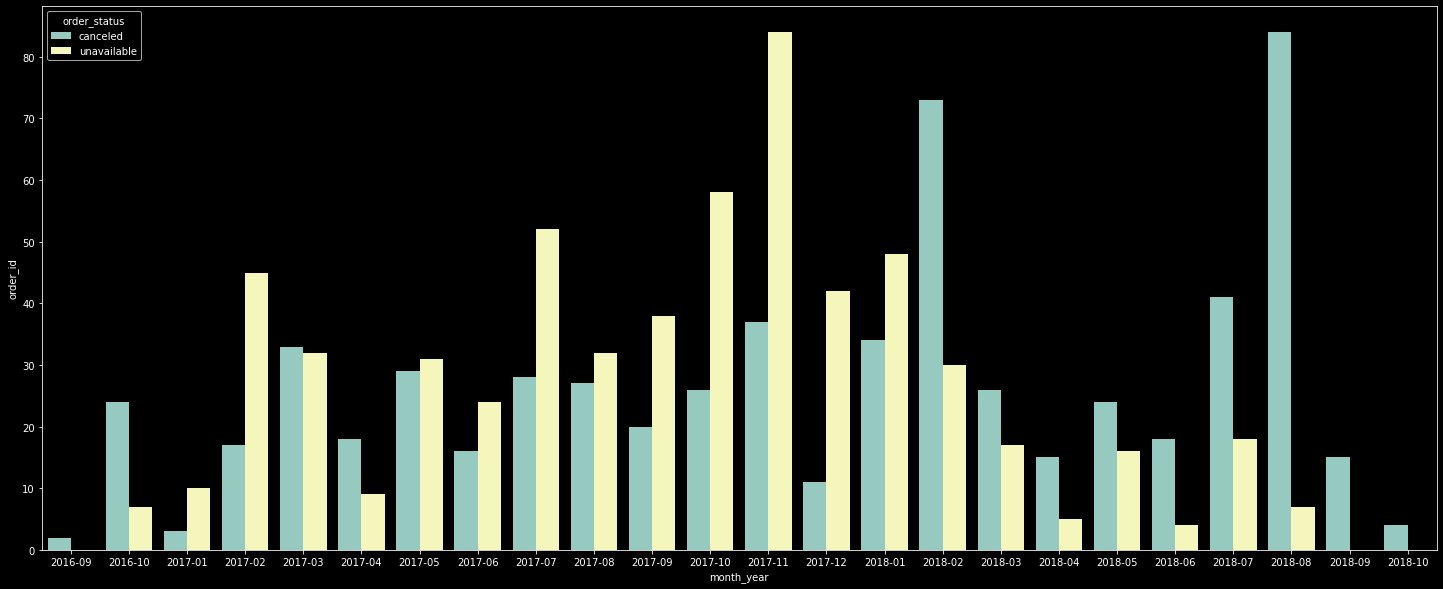

In [27]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(data = not_delivered, x='month_year', y='order_id', hue='order_status')

Сравним кол-во недоставленных заказов с общим кол-вом заказов по месяца, выброс `08-2018` `canceled` заказов может быть связан с большим кол-вом заказов

In [28]:
orders_fig = orders.query('order_successful in [1,0]')

gr_orders = orders_fig.groupby('month_year').agg({'order_id':'count'}).reset_index()

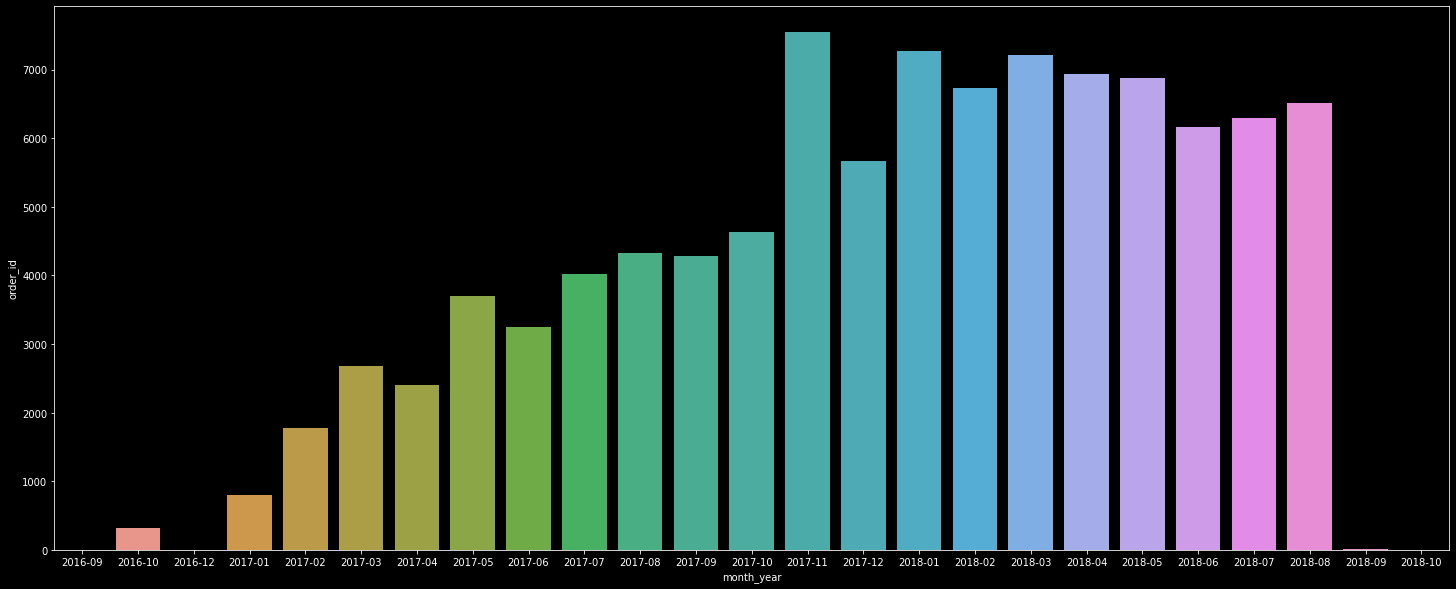

In [29]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(data = gr_orders, x='month_year', y='order_id')

### Вывод

В среднем ежемесячно `29` заказов не доставленно по причине `unavailable`,`26` по причине `canceled` соответственно\

`08-2018` резкий рост `canceled` заказов, не связан с общим кол-вом заказов

С `09-2018` прекращается поступление  заказов

## [На верх](#h0)

<a class="anchor" id="h3_3"></a>

<br/><br/>
<br/><br/>

### 3.3 По каждому товару определить, в какой день недели товар чаще всего покупается
Так же проведем расчет по гарантированно успешым наказам

Объеденим данные о заках и товарах в заказах, найдем день недели для каждого заказа

In [30]:
orders_items = orders.merge(items, on = 'order_id')

In [31]:
orders_items['day_of_week'] = orders_items['order_purchase_timestamp'].dt.day_name()

Посчитаем сколько товаров было проданно в каждый день недели, отсортируем по убыванию кол-ва товаров проданных в определенный день и оставим только первое вхождение товара, оно и будет соответствовать вопросу 

In [32]:
orders_items.query('order_successful == 1').groupby(['product_id','day_of_week'])\
    .agg({'order_id':'count'}).reset_index()\
    .sort_values('order_id', ascending = False).drop_duplicates(['product_id'], keep = 'first')

,product_id,day_of_week,order_id
15592,422879e10f46682990de24d770e7f83d,Wednesday,93
35743,99a4788cb24856965c36a24e339b6058,Monday,91
40174,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19705,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13266,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
23483,6413f8d0daa3a38887a14917589e7da5,Wednesday,1
23485,641444946fe3a839d726c32804cd1aff,Tuesday,1
23486,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1
23487,64187b994e1b15e6a59a6f72688fbea8,Friday,1


<a class="anchor" id="h3_4"></a>



### 3.4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [33]:
sales_of_week = orders_customers.query('order_successful == 1')

In [34]:
sales_of_week['count_week'] = sales_of_week.order_purchase_timestamp.dt.days_in_month/7

In [35]:
g = sales_of_week.groupby(['customer_unique_id','month_year','count_week'],as_index = False)\
    .agg({'order_id':'count'}).\
    sort_values('order_id', ascending = False).rename(columns = {'order_id': 'quantity_of_purchases'})

Посчитаем среднее кол-во покупом в неделю и удалим данные за первый не полный месяц

In [36]:
g['avg_orders_in_week'] = g['quantity_of_purchases']/g['count_week']
g.sort_values('month_year').drop(index = 48804)

,customer_unique_id,month_year,count_week,quantity_of_purchases,avg_orders_in_week
94952,ff68ad2883e793597f1c343dd6505f5d,2016-10,4.428571,1,0.225806
84729,e37af39d93f352f64ede45a151161d0c,2016-10,4.428571,1,0.225806
45452,7a2679d6c164f6b6a2f36daf1b2fbc9d,2016-10,4.428571,1,0.225806
85864,e6a1d274cbba12da4cd29eb462b34be5,2016-10,4.428571,1,0.225806
86152,e75b9df782b21f27d61449864774108b,2016-10,4.428571,1,0.225806
...,...,...,...,...,...
15860,2aa42e268eb5208e68313f4b5df1f4f9,2018-08,4.428571,1,0.225806
10703,1c89ad9872748220ba627f9dbf36d6bc,2018-08,4.428571,1,0.225806
10699,1c86168e4d62fcd4b65534c945e3c6ac,2018-08,4.428571,1,0.225806
45447,7a22d14aa3c3599238509ddca4b93b01,2018-08,4.428571,1,0.225806


<a class="anchor" id="h3_5"></a>

<br/><br/>
<br/><br/>

### 3.5 В период с января по декабрь выявить когорту пользователей с самым высоким retention на 3й месяц.

In [37]:
cohort_analysis = orders.merge(customers ,on = 'customer_id').query('order_successful == 1')

In [38]:
c = cohort_analysis.groupby('customer_unique_id',as_index = False).agg({'month_year': 'min'}).\
    merge(cohort_analysis[['customer_unique_id','month_year']], on = 'customer_unique_id').\
    groupby(['month_year_x','month_year_y'],as_index = False).agg({'customer_unique_id':'count'}).\
    sort_values('month_year_y').\
    rename(columns = {'month_year_x': 'first_order_cohort','month_year_y':'orders_date'})

In [39]:
c['month'] = (c['orders_date'] - c['first_order_cohort']).apply(attrgetter('n'))

In [40]:
aa = c.query('month == 0').groupby('first_order_cohort')['customer_unique_id'].sum()

In [41]:
user_retention = c.query('month <= 12').pivot(columns='month', index = 'first_order_cohort', values='customer_unique_id')
user_retention.divide(aa, axis=0)\
    .style.background_gradient(cmap='PuBu')\
    .highlight_null('white')\
    .format("{:.2%}", na_rep="")

month,0,1,2,3,4,5,6,7,8,9,10,11,12
first_order_cohort,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.38%,,,0.38%,,0.38%,
2016-12,100.00%,100.00%,,,,,,,,,,,
2017-01,100.00%,0.27%,0.27%,0.13%,0.40%,0.13%,0.40%,0.13%,0.13%,,0.40%,0.13%,0.67%
2017-02,100.00%,0.18%,0.31%,0.12%,0.43%,0.12%,0.24%,0.18%,0.06%,0.18%,0.12%,0.31%,0.12%
2017-03,100.00%,0.47%,0.35%,0.47%,0.35%,0.16%,0.16%,0.31%,0.31%,0.08%,0.35%,0.12%,0.20%
2017-04,100.00%,0.66%,0.26%,0.22%,0.26%,0.26%,0.39%,0.31%,0.31%,0.18%,0.26%,0.09%,0.04%
2017-05,100.00%,0.48%,0.46%,0.28%,0.28%,0.34%,0.46%,0.14%,0.26%,0.31%,0.26%,0.34%,0.23%
2017-06,100.00%,0.52%,0.42%,0.42%,0.32%,0.39%,0.36%,0.23%,0.13%,0.19%,0.29%,0.39%,0.16%


Самый высокий `retention` на третий месяц у когорты пользователей совершивших первую покупку `2017-03` и составляет `0.47%`

<a class="anchor" id="h3_6"></a>

<br/><br/>

### 3.6 Построй RFM-сегментацию пользователей

**R** (recency) - время от последней покупки пользователя до текущей даты;\
**F** (frequency) - суммарное количество покупок у пользователя за всё время;\
**M** (monetary) - сумма покупок за всё время

Объеденим данные о заказах и пользователях, оставим успешные заказы

In [47]:
orde = orders.merge(customers ,on = 'customer_id')\
    .query('order_successful == 1')

## `recency`

Для нахождения `recency` за текущую дату возьмем время последнего созданного заказа и  вычтем из него дату последней покупки пользователя

In [48]:
r = orde.groupby('customer_unique_id')\
        .agg({'order_purchase_timestamp':['max']})['order_purchase_timestamp'].reset_index()
r['raz'] = (orders.order_purchase_timestamp.max() - r['max'] ).dt.days

Оставим данные за год и посмотрим на распределение дней от последней покупки пользователя до текущей даты

In [49]:
r = r.query('raz <= 365').sort_values('raz')

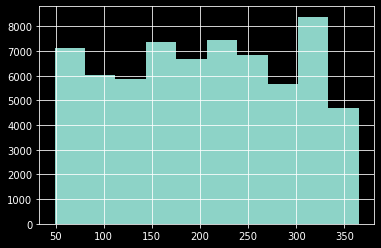

In [50]:
r.raz.hist()


Так как Распределение равномерное, хоть и начинается с 49 дня, разделю получившуюся разницу на 4 равные группы.\
Которые в себя вклбчат следующие промежутки:

In [51]:
pd.qcut(r.raz,4).unique()

[(48.999, 128.0], (128.0, 206.0], (206.0, 279.0], (279.0, 365.0]]
Categories (4, interval[float64]): [(48.999, 128.0] < (128.0, 206.0] < (206.0, 279.0] < (279.0, 365.0]]

In [52]:
r['r'] = pd.qcut(r.raz,4,labels=[4,3,2,1])

In [69]:
r.head()

,customer_unique_id,max,raz,r
61030,a712a430955027da5bc257a10073a390,2018-08-28 21:56:30,49,4
64207,afbcfd0b9c5233e7ccc73428526fbb52,2018-08-29 08:46:11,49,4
66810,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,49,4
57656,9dfcc502727549f99c9f73dbd28b35e9,2018-08-28 22:30:32,49,4
44582,7a22d14aa3c3599238509ddca4b93b01,2018-08-29 12:25:59,49,4


##  `frequency`

Посчитаю суммарное количество покупок у пользователя за всё время

In [54]:
f = orde.groupby('customer_unique_id', as_index = False)\
    .agg({'order_id':'count'}).sort_values('order_id',ascending = False)

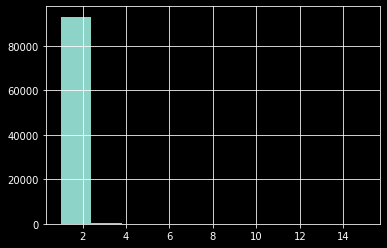

In [55]:
f.order_id.hist()

Так как кол-во заказов на одного пользователя не равномерно, будем считать что;\
`1 покупка` - 1 балл\
`2 покупки` - 2 балла\
`3-4 покупок` - 3 балла\
`5 и более покупок` - 4 балла

In [56]:
f['f'] = pd.cut(f.order_id,bins = [0,1,2,4,f.order_id.max()] ,labels=[1, 2, 3, 4])

In [57]:
f.groupby('f')['order_id'].agg(set)

f
1                 {1}
2                 {2}
3              {3, 4}
4    {5, 6, 7, 9, 15}
Name: order_id, dtype: object

In [58]:
f.groupby('f')['order_id'].agg(['count'])

,count
f,
1,90537
2,2572
3,209
4,19


In [67]:
f.head()

,customer_unique_id,order_id,f
51421,8d50f5eadf50201ccdcedfb9e2ac8455,15,4
22774,3e43e6105506432c953e165fb2acf44c,9,4
10058,1b6c7548a2a1f9037c1fd3ddfed95f33,7,4
36700,6469f99c1f9dfae7733b25662e7f1782,7,4
73906,ca77025e7201e3b30c44b472ff346268,7,4


## `monetary`

Найдем `monetary`, добавим данные от товарах\
Посчитаем сумму заказов для каждого пользователя за всё время

In [60]:
merge = orde.merge(items[['order_id','price']] , on = 'order_id')

In [61]:
m = merge.groupby('customer_unique_id',as_index = False)\
    .agg({'price':'sum'}).sort_values('price',ascending = False)

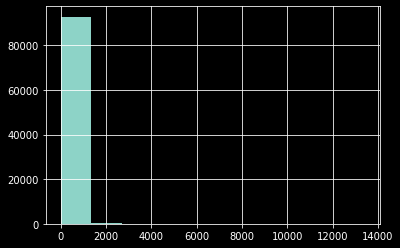

In [62]:
m.price.hist()

Так же распределение скошено, за границы при оценке возьмем:\
сумма заказа;
   * `0-100` - 1 балл
   * `100-500` - 2 балла
   * `500 - 1000` - 3 балла
   * `более 1000` - 4 балла

In [63]:
m['m'] = pd.cut(m.price,bins = [0,100,500,1000,m.price.max()],labels=[1, 2, 3,4])

In [65]:
m

,customer_unique_id,price,m
3724,0a0a92112bd4c708ca5fde585afaa872,13440.00,4
79618,da122df9eeddfedc1dc1f5349a1a690c,7388.00,4
43161,763c8b1c9c68a0229c42c9fc6f662b93,7160.00,4
80445,dc4802a71eae9be1dd28f5d788ceb526,6735.00,4
25431,459bef486812aa25204be022145caa62,6729.00,4
...,...,...,...
75606,cf3839da0d9492ad151690b65f45d800,2.99,1
69015,bd06ce0e06ad77a7f681f1a4960a3cc6,2.29,1
18098,317cfc692e3f86c45c95697c61c853a6,2.20,1
65540,b38211bd797f4fdd81a98b9d1754b606,0.85,1


In [64]:
m.groupby('m')['price'].agg(['count'])

,count
m,
1,53585
2,36141
3,2673
4,938


Объеденим полученные данные, создадим новые колонки с `rmf-коэффицентом и кластером` из получившихся значений

In [60]:
rfm = r[['customer_unique_id','r']].\
    merge(f[['customer_unique_id','f']], on = 'customer_unique_id').\
    merge(m[['customer_unique_id','m']], on = 'customer_unique_id')

In [61]:
rfm['ratio'] = round((rfm.r.astype(int) + rfm.f.astype(int) + rfm.m.astype(int))/3,2)

In [62]:
rfm['rfm'] = (rfm.r.astype(str) + rfm.f.astype(str) + rfm.m.astype(str))

In [63]:
rfm = rfm.sort_values('ratio', ascending = False)

In [64]:
rfm.head()

,customer_unique_id,r,f,m,ratio,rfm
14384,fe81bb32c243a86b2f86fbf053fe6140,4,4,4,4.00,444
2104,394ac4de8f3acb14253c177f0e15bc58,4,4,3,3.67,443
409,dc813062e0fc23409cd255f7f53c7074,4,4,3,3.67,443
15028,397b44d5bb99eabf54ea9c2b41ebb905,4,3,4,3.67,434
6964,4e1cce07cd5937c69dacac3c8b13d965,4,3,4,3.67,434


Создам сигменты по RMF оценке

`Champions` - Покупал недавно, заказывает часто и тратит больше всего.\
`Loyal`     - Покупал недавно, покупал часто, чек высокий\
`Potential` Loyalist  - Покупал недавно один раз на большую сумму \
`New Customers` - Покупал недавно один раз\
`Promising` - Покупает регулярно на маленькую сумму\
`Cannot Lose Them` - Покупал регулярно и на большие суммы, но давно\
`Need attention` - Покупал на большие суммы, но давно \
`About To Sleep` - Покупал часто, но давно\
`Inactive` - Купил однажды, давно


In [65]:
segments = {
    r'[3-4][3-4][2-4]': 'Champions',
    r'[3-4]2[3-4]'    : 'Loyal',
    r'[3-4]1[3-4]'    : 'Potential Loyalist',
    r'[3-4]1[1-2]'    : 'New Customers',
    r'[3-4][2-3][1-2]': 'Promising',
    r'[1-2][3-4][3-4]': 'Cannot Lose Them',
    r'[1-2][1-2][3-4]': 'Need attention',  
    r'[1-2][2-4][1-2]': 'About To Sleep',
    r'[1-2]1[1-2]'    : 'Inactive'
}

rfm['segment'] = rfm['rfm'].replace(segments, regex=True)

In [66]:
rfm.head()

,customer_unique_id,r,f,m,ratio,rfm,segment
14384,fe81bb32c243a86b2f86fbf053fe6140,4,4,4,4.00,444,Champions
2104,394ac4de8f3acb14253c177f0e15bc58,4,4,3,3.67,443,Champions
409,dc813062e0fc23409cd255f7f53c7074,4,4,3,3.67,443,Champions
15028,397b44d5bb99eabf54ea9c2b41ebb905,4,3,4,3.67,434,Champions
6964,4e1cce07cd5937c69dacac3c8b13d965,4,3,4,3.67,434,Champions


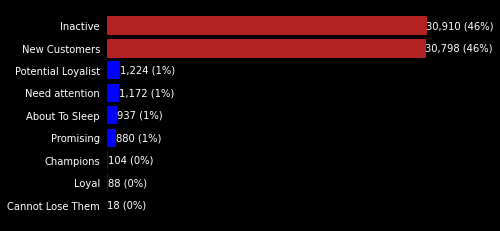

In [67]:
segments_counts = rfm['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='blue')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['New Customers','Inactive']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left')

    
fig.show()

По результатам RFM - оценки, создали сигменты пользователей в зависимости от их активности, кол-ва покупок и суммы всех заказов.\
В очередной раз подтвердили что основаня часть пользователей покупает единожды.\
~5% Пользователей проявляли активность в течении года 

<a class="anchor" id="h4"></a>



# Выводы

В данных о заказах наблюдаются несоответствия статусам\
Рост количества заказов ежемесячно рос до `2018-08`, после мы имеем только закрытые заказы\
`97%` наших пользователей совершили всего одну покупку\
Самый высокий `retention` на третий месяц у когорты пользователей совершивших первую покупку `2017-03` и составляет `0.47%`